## Install Requirements

In [94]:
!pip install torch
!pip install transformers rouge_score bert_score datasets peft bitsandbytes accelerate
!pip install evaluate
!pip install rouge_score
!pip install bert_score

In [2]:
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.tokenization_utils_base import BatchEncoding
import torch
import logging
import string
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score
from datasets import load_dataset, load_metric
from tqdm.auto import tqdm
import json
from peft import AutoPeftModelForCausalLM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(level=logging.INFO)

## Load Model


In [3]:
model_name = 'javijer/llama2_alpaca_7b'
model = AutoModelForCausalLM.from_pretrained(
    model_name, # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit = True,
    output_hidden_states=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

## Load Dataset

In [4]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

from datasets import load_dataset
dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 51760
})

In [5]:
import random

random.seed(1)

test_indexes = random.sample(range(len(dataset)), 20)
test_indexes

[8805,
 37303,
 50054,
 4135,
 16716,
 7727,
 32468,
 49870,
 29457,
 30949,
 42702,
 24878,
 51689,
 13759,
 6151,
 31972,
 1857,
 25546,
 28361,
 39809]

In [6]:
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

In [7]:
test_dataset = dataset.select(test_indexes)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

## Generate Responses

In [46]:
def generate_text(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    prompt: str,
    max_num_tokens: int = 25,
    top_k: int = 5,
    layer: int = 8,
    temperature: float = 1.0,
    stop_token_ids: list = [],
    stop_words: list = [],
    eos_weight: float = 2.0,
    enable_logging: bool = False
) -> str:
    """
    Generate text using a language model.

    Args:
        model (model): The language model.
        tokenizer (model): The tokenizer corresponding to the model.
        prompt (str): The initial text to start generation from.
        num_tokens (int, optional): The number of tokens to generate. Defaults to 5.
        top_k (int, optional): The number of top tokens to consider for sampling. Defaults to 5.
        layer (int, optional): The layer of the model to use for generation. Defaults to 8.
        temperature (float, optional): The temperature for softmax. Defaults to 1.0.
        stop_token_ids (list, optional): List of token ids that will end generation if sampled. Defaults to [].
        stop_words (list, optional): List of words that will end generation if sampled. Defaults to [].
        eos_weight (float, optional): The weight to assign to the EOS token. Defaults to 2.0.
        enable_logging (bool, optional): Enable logging for debugging. Defaults to False.

    Returns:
        str: The generated text.
    """
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)
    print(layer)
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs.to(device)

    # Get the EOS token ID
    eos_token_id = tokenizer.eos_token_id
    stop_token_ids.append(eos_token_id)
    output_tokens = []
    all_logits = []

    # Generate num_tokens tokens
    for i in range(max_num_tokens):

        prob_logits = {}

        # Forward pass through the model
        outputs = model(**inputs)

        # Get the output of the specified layer
        layer_output = outputs.hidden_states[layer]

        # Pass the output through the final linear layer
        logits = model.lm_head(layer_output)

        # Apply softmax to get probabilities
        probabilities = F.softmax(logits / temperature, dim=-1)

        # Increase the weight of the EOS token
        probabilities[0, -1, eos_token_id] *= eos_weight

        # Get the probabilities of the top k tokens
        top_k_probabilities, top_k_indices = torch.topk(probabilities[0, -1], top_k)

        # Normalize the top k probabilities
        top_k_probabilities /= torch.sum(top_k_probabilities)

        # Sample from the top k probability distribution
        sampled_token_id = top_k_indices[torch.multinomial(top_k_probabilities, 1)].item()
        output_tokens.append(sampled_token_id)

        # Decode the token id back into text
        sampled_token_text = tokenizer.decode([sampled_token_id])
        sampled_token = {'input_ids': torch.tensor([[1, sampled_token_id]]), 'attention_mask': torch.tensor([[1, 1]])}

        # If the sampled token is a stop token or stop word, return the generated text
        if sampled_token_id in stop_token_ids or sampled_token_text in stop_words:
            generated_text = tokenizer.decode(inputs['input_ids'][0])
            pure_output = tokenizer.decode(output_tokens)
            return {'text':generated_text,'output':pure_output,'prompt':prompt, 'logits': all_logits}

        combined_input_ids = torch.cat((inputs['input_ids'].detach().cpu(), sampled_token['input_ids'][:,1:]), dim=-1)
        combined_attention_mask = torch.cat((inputs['attention_mask'].detach().cpu(), sampled_token['attention_mask'][:,1:]), dim=-1)

        inputs = BatchEncoding({'input_ids': combined_input_ids, 'attention_mask': combined_attention_mask}).to(device)

        # Log the token and top k tokens if logging is enabled
        if enable_logging:
            print(f'Token: {sampled_token_text}')
            print('      -- Top tokens --')
            for i in range(top_k):
                token = tokenizer.decode([top_k_indices[i].item()])
                probability = top_k_probabilities[i].item()
                prob_logits[token] = probability
                print(f'   {token}: {probability}')

            all_logits.append(prob_logits)
            print()

    generated_text = tokenizer.decode(inputs['input_ids'][0])
    pure_output = tokenizer.decode(output_tokens)
    return {'text':generated_text,'output':pure_output,'prompt':prompt, 'logits': all_logits}

In [56]:
responses = []
for layer in range(32):
  responses.append([])
  for instruction, input in zip(test_dataset['instruction'], test_dataset['input']):
    prompt = alpaca_prompt.format(
      instruction,
      input,
      "",
    )

    output = generate_text(model, tokenizer, prompt, top_k = 10, temperature = 0.1, max_num_tokens=128, layer = layer, enable_logging=True)
    responses[layer].append(output)

Streaming output truncated to the last 5000 lines.

Token: a
      -- Top tokens --
   a: 1.0
   within: 2.4318695068359375e-05
   in: 1.0132789611816406e-05
   <unk>: 0.0
   : 0.0
    : 0.0
   : 0.0
   : 0.0
   <s>: 0.0
   </s>: 0.0

Token: common
      -- Top tokens --
   common: 0.9990234375
   standard: 0.00070953369140625
   r: 0.0001232624053955078
   <unk>: 0.0
   : 0.0
    : 0.0
   : 0.0
   : 0.0
   <s>: 0.0
   </s>: 0.0

Token: and
      -- Top tokens --
   and: 1.0
   <s>: 0.0
    : 0.0
   : 0.0
   : 0.0
   <unk>: 0.0
   </s>: 0.0
   : 0.0
   : 0.0
   : 0.0

Token: in
      -- Top tokens --
   in: 1.0
   <s>: 0.0
    : 0.0
   : 0.0
   : 0.0
   <unk>: 0.0
   </s>: 0.0
   : 0.0
   : 0.0
   : 0.0

Token: exp
      -- Top tokens --
   exp: 1.0
   <s>: 0.0
    : 0.0
   : 0.0
   : 0.0
   <unk>: 0.0
   </s>: 0.0
   : 0.0
   : 0.0
   : 0.0

Token: ensive
      -- Top tokens --
   ensive: 1.0
   <s>: 0.0
    : 0.0
   : 0.0
   : 0.0
   <unk>: 0.0
   </s>: 0.0
   

In [102]:
responses[0][0].keys()

dict_keys(['text', 'output', 'prompt', 'logits'])

In [103]:
responses[1][-1]['output']

',. in to … in in to today  …untimeărillas. and for\n, in as … ( forese mv ( to … I.\n in forums↳zak≫uclidedział in and\n today Mor. konn, …zetek. and telt in on today …◄ContentView…🌍achine Resses. in ( in on top r to … in forPortail,Sito! …◄ernerstand ( virtuel ProfildPortail. in.. as ( in. forged and\n … in to on beh for … in\n in\n …idenote beskre, and\n … in (?) Référence Maz. (textt\n.'

## Visualize Token Probability Distribution

Layer 8



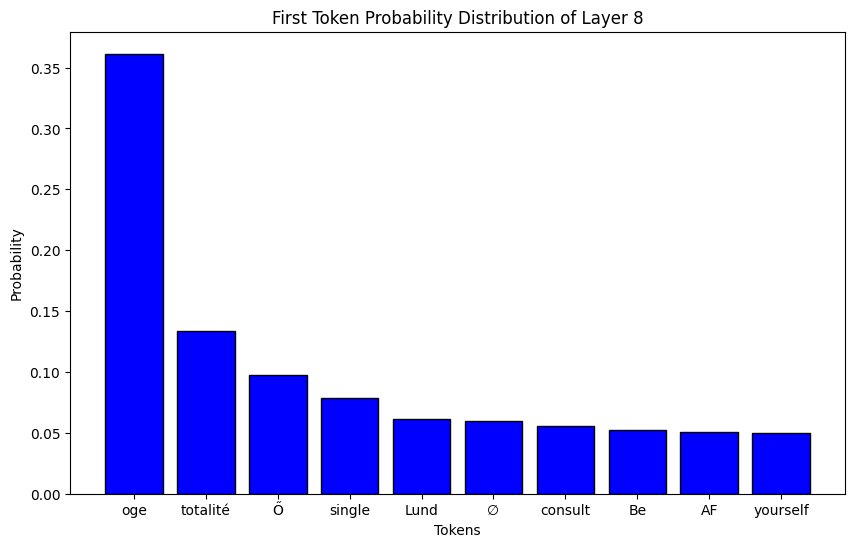

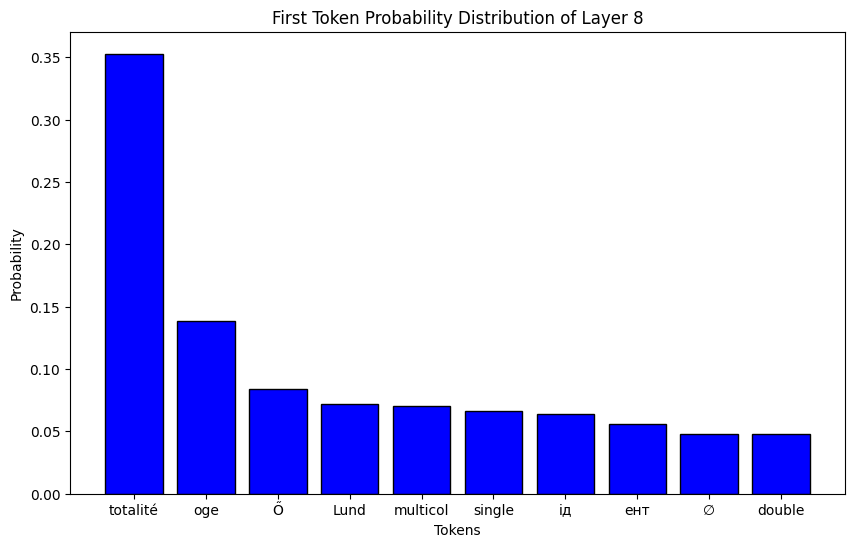

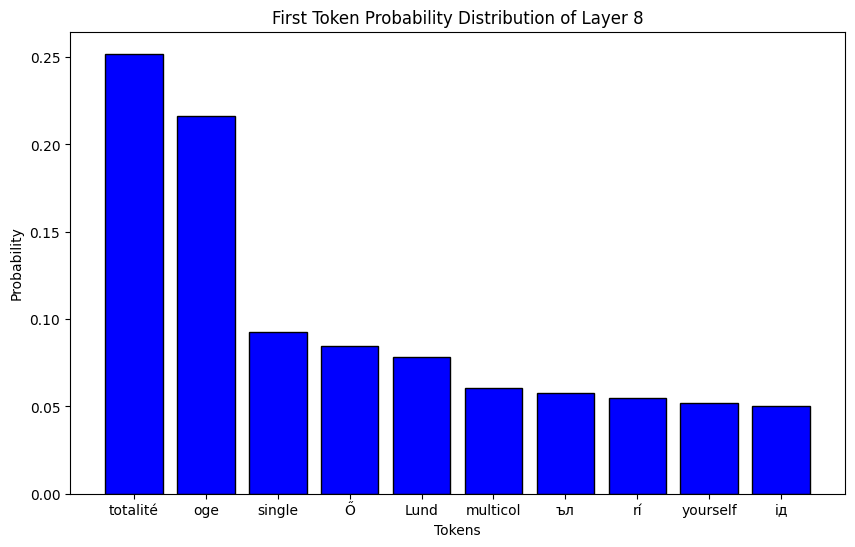



Layer 16



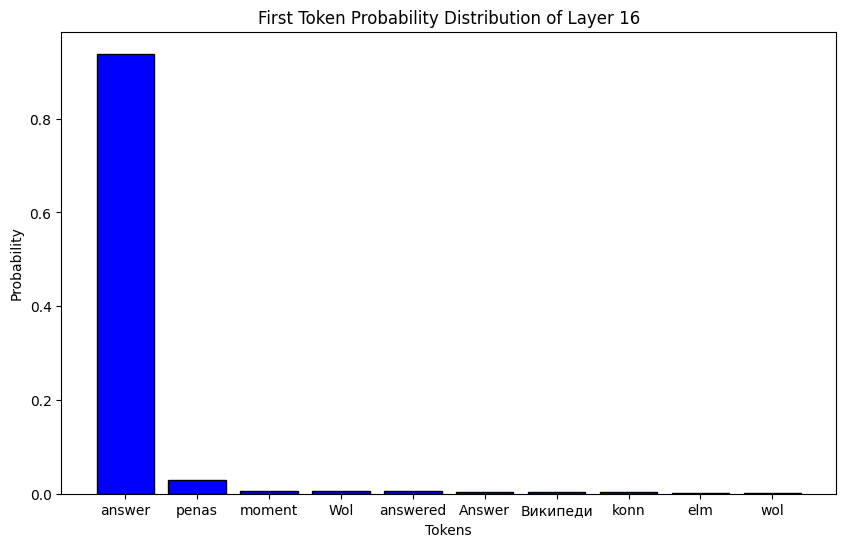

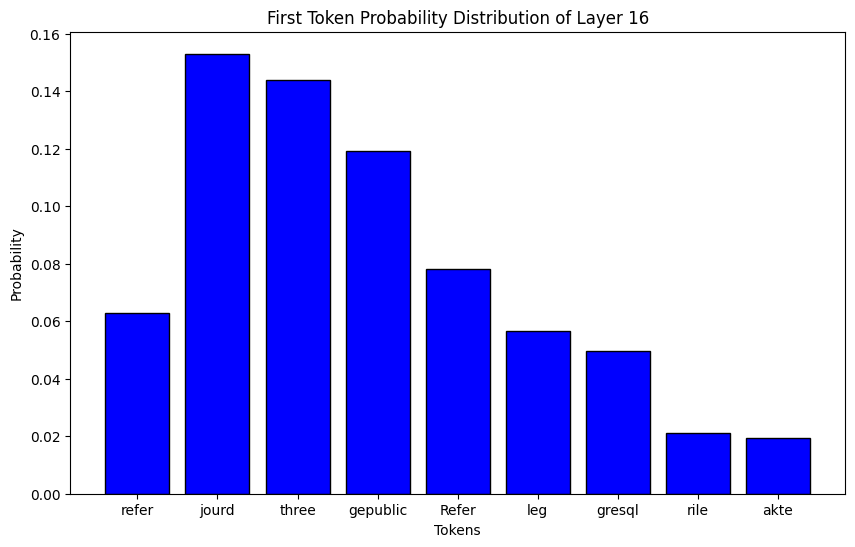

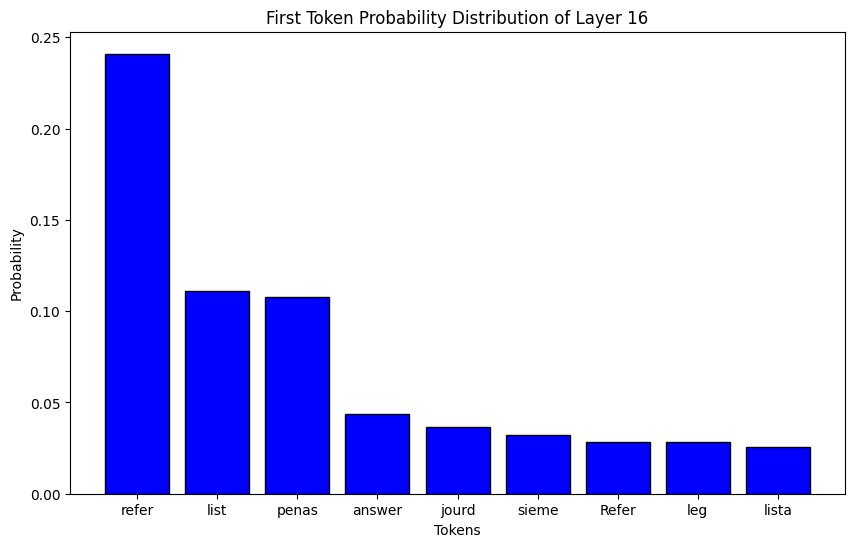



Layer 24



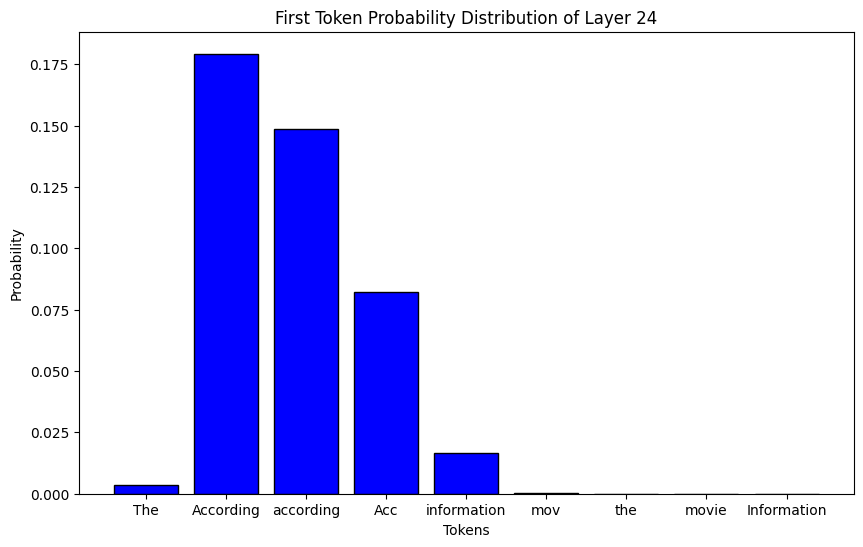

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


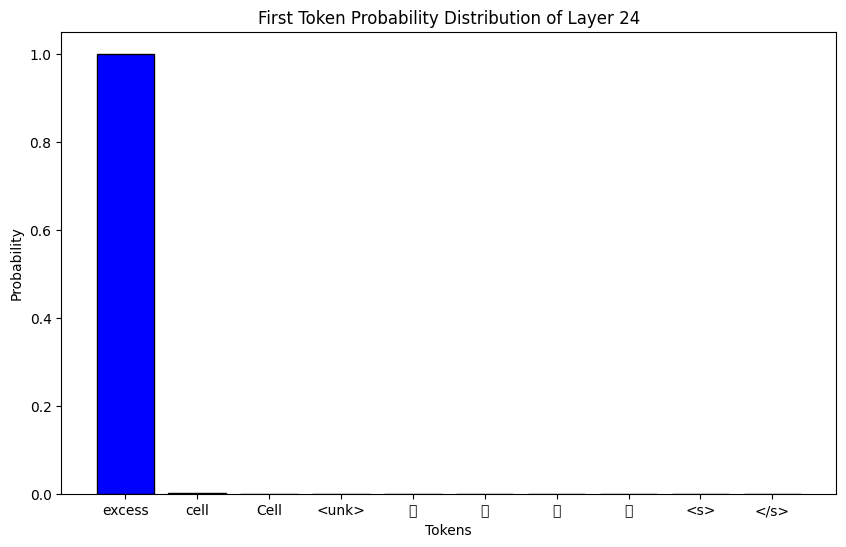

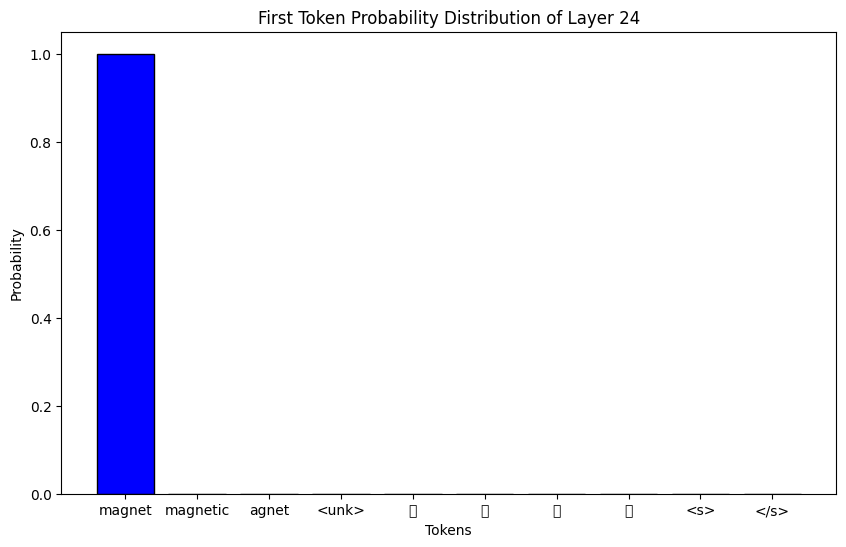



Layer 32



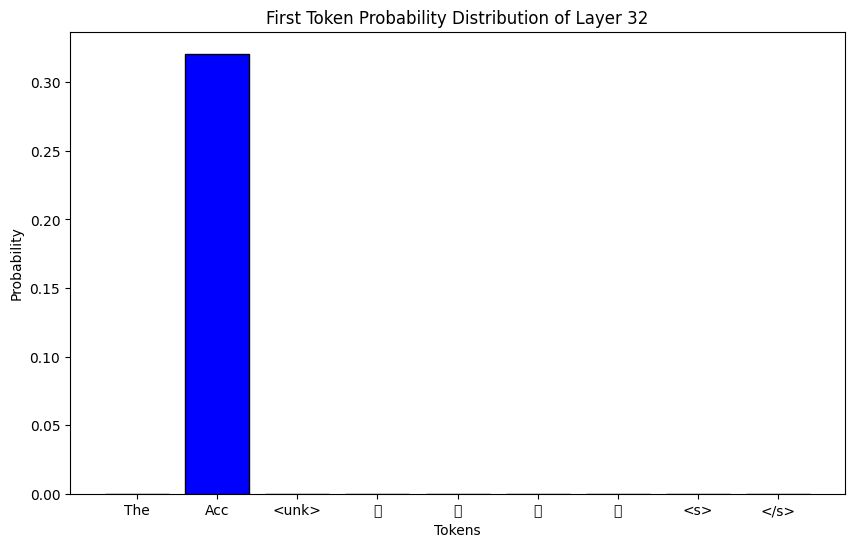

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


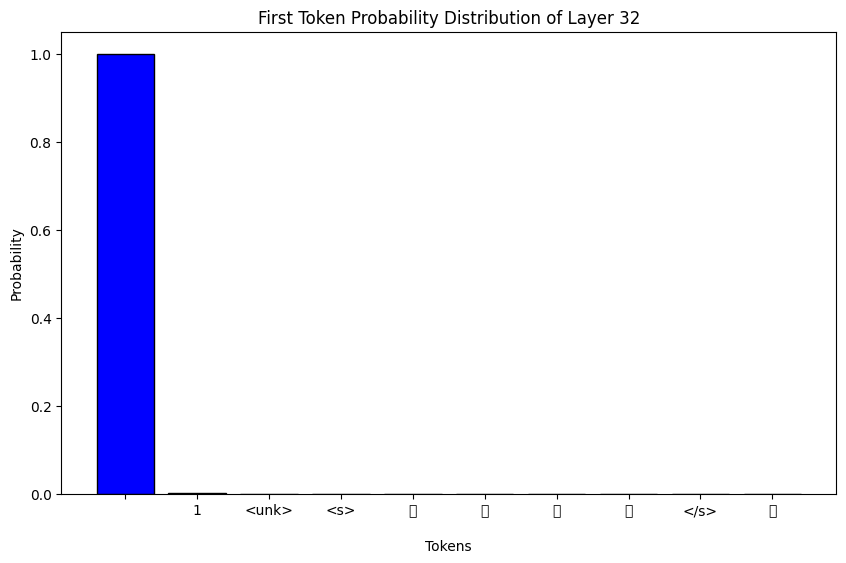

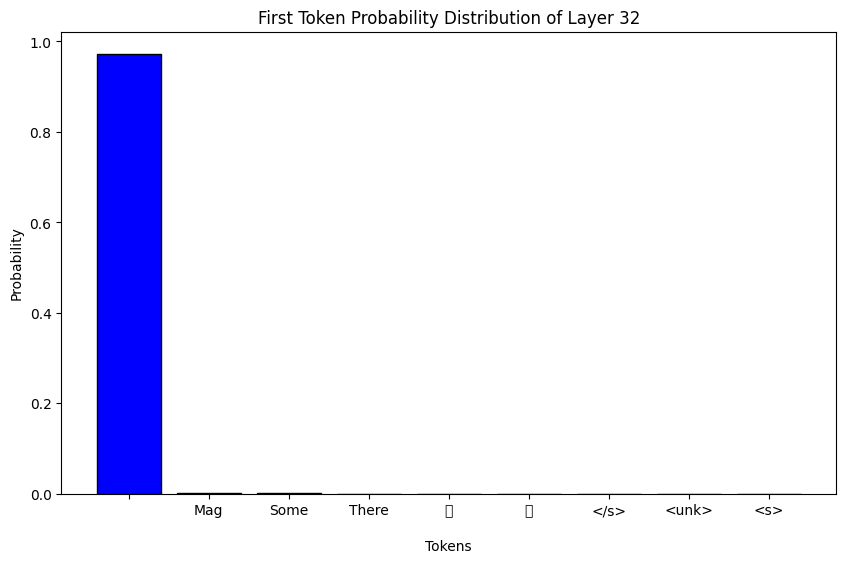

In [104]:
import matplotlib.pyplot as plt

selected_layers = [8, 16, 24, 32]
max_examples = 3

for layer, outputs in enumerate(responses):
  if(layer + 1 not in selected_layers): continue

  print(f"Layer {layer + 1}\n")
  for i in range(max_examples):
    output = outputs[i]
    tokens = output['logits'][0].keys()
    probabilities = output['logits'][0].values()

    # Create a bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(tokens, probabilities, color='blue', edgecolor='black')
    plt.xlabel("Tokens")
    plt.ylabel("Probability")
    plt.title(f"First Token Probability Distribution of Layer {layer + 1}")
    plt.show()

    print("\n")


## Evaluate

In [105]:
import evaluate

selected_layers = [8, 16, 24, 32]
# Note: Not evaluating CodeBLEU because this is not code
references = test_dataset['output']
scores = {
    "Layers": [f"Layer {layer}" for layer in selected_layers],
    "BLEU": [],
    "Rouge-L": [],
    "BERTScore": [],
}

In [106]:
layer_outputs = []
# Process Outputs
for layer, outputs in enumerate(responses):
  if(layer + 1 not in selected_layers): continue

  processed_outputs = []
  for output in outputs:
    output = output['output'].replace(tokenizer.eos_token, '')
    output = output.replace(tokenizer.bos_token, '')
    processed_outputs.append(output)
  layer_outputs.append(processed_outputs)

In [107]:
# BLEU Score
bleu = evaluate.load("bleu")

for predictions in layer_outputs:
  results = bleu.compute(predictions=predictions, references=references)
  scores['BLEU'].append(round(results['bleu'], 3))
  print(results)

{'bleu': 0.0, 'precisions': [0.0280970625798212, 0.0, 0.0, 0.0], 'brevity_penalty': 0.11729776334577525, 'length_ratio': 0.31816334823242587, 'translation_length': 783, 'reference_length': 2461}
{'bleu': 0.0, 'precisions': [0.036016949152542374, 0.0, 0.0, 0.0], 'brevity_penalty': 0.014787352108440748, 'length_ratio': 0.19179195449004469, 'translation_length': 472, 'reference_length': 2461}
{'bleu': 0.0077117940574225035, 'precisions': [0.05623608017817372, 0.014076576576576577, 0.005691519635742743, 0.0034522439585730723], 'brevity_penalty': 0.690549749246932, 'length_ratio': 0.7297846403900853, 'translation_length': 1796, 'reference_length': 2461}
{'bleu': 0.01953822370516023, 'precisions': [0.3975501113585746, 0.16081540203850508, 0.07603686635944701, 0.031652989449003514], 'brevity_penalty': 0.17542660631893534, 'length_ratio': 0.36489232019504264, 'translation_length': 898, 'reference_length': 2461}


In [108]:
# Rouge-L Score
rouge = evaluate.load('rouge')

for predictions in layer_outputs:
  results = rouge.compute(predictions=predictions, references=references)
  scores['Rouge-L'].append(round(results['rougeL'], 3))
  print(results)

{'rouge1': 0.004958810235474229, 'rouge2': 0.0, 'rougeL': 0.004460731276382958, 'rougeLsum': 0.004309907028431486}
{'rouge1': 0.0015931068683362262, 'rouge2': 0.0, 'rougeL': 0.0015931068683362262, 'rougeLsum': 0.0015931068683362262}
{'rouge1': 0.0913669021563644, 'rouge2': 0.03226937715272553, 'rougeL': 0.08623302746147968, 'rougeLsum': 0.08851175371210585}
{'rouge1': 0.2254451285694945, 'rouge2': 0.11026389114495849, 'rougeL': 0.17346006699207162, 'rougeLsum': 0.20414461414050133}


In [109]:
# BERTScore Score
import numpy as np

bertscore = evaluate.load('bertscore')


for predictions in layer_outputs:
  results = bertscore.compute(predictions=predictions, references=references, lang="en")
  precision = np.average(results["precision"])
  recall = np.average(results["recall"])
  f1 = np.average(results["f1"])
  result = round(f1, 3)
  scores['BERTScore'].append(result)
  print(result)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.728


0.69
0.76
0.632


## Result Table

In [110]:
import pandas as pd

# Comparison Table
df = pd.DataFrame(scores)

print(df)

     Layers   BLEU  Rouge-L  BERTScore
0   Layer 8  0.000    0.004      0.728
1  Layer 16  0.000    0.002      0.690
2  Layer 24  0.008    0.086      0.760
3  Layer 32  0.020    0.173      0.632
